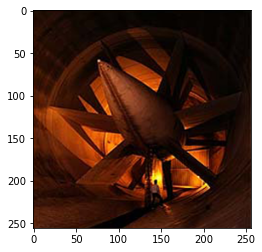

In [2]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

test_image = 'C:/Users/ISIA/Pictures/test_image.jpg'

rgbimg = cv2.cvtColor(cv2.imread(test_image,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)  
# 이미지 물러오기위해 cv2 사용(이미지 불러올때만 사용함)

plt.imshow(rgbimg)

In [3]:
def rgb2hsi(rgbimg):
    # RGB 이미지 -> hsi 이미지
    # 색상 값을 [0,255]로 정규화.
    rows, cols = rgbimg[:,:,0].shape  # 각각의 채널 이미지 밝기는 같아야함.
    s = np.zeros((rows, cols), dtype=np.float32)  # s 초기화
    i = np.zeros((rows, cols), dtype=np.float32)  # i 초기화
    red = rgbimg[:,:,0]/255     # 0-1로 정규화
    green = rgbimg[:,:,1]/255
    blue = rgbimg[:,:,2]/255
    h = []
    for r in range(rows):
        for c in range(cols):
            RG = red[r,c]-green[r,c]+0.001  # Red-Green, 정의되지 않은 값을 방지하기 위해 상수 추가
            RB = red[r,c]-blue[r,c]+0.001  # Red-Blue
            GB = green[r,c]-blue[r,c]+0.001  # Green-Blue
            theta = np.arccos(np.clip(((0.5*(RG+RB))/(RG**2+RB*GB)**0.5), -1, 1))  # Still in radians
            theta = np.degrees(theta)  # Convert to degrees
            if blue[r,c] <= green[r,c]:
                h.append(theta)
            else:
                h.append(360 - theta)
    # 색상 범위는 matplotlib에 의해 표시용으로 0-255로 자동 조정됩니다.
    # hsi2rgb 함수에서는 수동으로 0~360 범위로 변환해야함.
    h = np.array(h, dtype=np.int64).reshape(rows, cols)  # 색상을 NumPy array로 변환
    h = ((h - h.min()) * (1/(h.max() - h.min()) * 360))  # Scale h to 0-360
    minRGB = np.minimum(np.minimum(red, green), blue)
    s = 1-((3/(red+green+blue+0.001))*minRGB)  # 0.001을 추가하여 0으로 나누지 않도록 한다.
    i = (red+green+blue)/3  # Intensity: 0-1
    return h, s, i

def hsi2rgb(hsiimg):
    # hsi 이미지 -> RGB 이미지
    rows, cols = hsiimg[:,:,0].shape  # 각각의 채널 이미지 밝기는 같아야함.
    h = hsiimg[:,:,0]  # 0-360
    h = ((h - h.min()) * (1/(h.max() - h.min()) * 360))  # Scale h to 0-360
    s = hsiimg[:,:,1]  # 0-1
    i = hsiimg[:,:,2]  # 0-1
    rd, gr, bl = [], [], []  # r, g ,b를 빈 어레이로 초기화.
    for r in range(rows):
        for c in range(cols):
            if (h[r,c] >= 0 and h[r,c] <= 120):
                red = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                blue = (1-s[r, c])/3
                rd.append(red)
                gr.append(1-(red+blue))
                bl.append(blue)
            elif (h[r,c] > 120 and h[r,c] <= 240):
                h[r, c] = h[r, c]-120
                red = (1-s[r, c])/3
                green = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                rd.append(red)
                gr.append(green)
                bl.append(1-(red+green))
            elif (h[r,c] > 240 and h[r,c] <= 360):
                h[r, c] = h[r, c]-240
                green = (1-s[r, c])/3
                blue = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                rd.append(1-(green+blue))
                gr.append(green)
                bl.append(blue)
    rd = np.multiply(rd, 3*i.flatten()).reshape(rows, cols)  # R = r*3*i, 여기서 r은 이전 행의 rd
    gr = np.multiply(gr, 3*i.flatten()).reshape(rows, cols)
    bl = np.multiply(bl, 3*i.flatten()).reshape(rows, cols)
    return rd, gr, bl

In [4]:
def histogram_equalization(img):
    # hsi 이미지 평할화
    val, count = np.unique(img[:,:,-1], return_counts=True)  # 명도(I) 채널에서 균등화
    val = (val*255).astype(np.uint8)  # val을 255로 변환
    pdf = np.divide(count, sum(count))  # 확률 밀도 함수 pr(rk)
    cdf = (val.max()*np.cumsum(pdf)).astype(np.int32)  # 누적 밀도 함수
    mp = np.arange(0, val.max()+1)
    mp[val] = cdf  # 이전 픽셀 값을 새 픽셀 값에 매핑
    mul = np.multiply(img[:,:,-1], 255).astype(np.uint8)  # 일시적으로 255로 변환
    img[:,:,-1] = mp[mul]  # 픽셀 값 업데이트
    img[:,:,-1] = img[:,:,-1]/255  # 다시 0-1로 변환
    r, g, b = hsi2rgb(img)  # HSI을 RGB로 변환
    heimage = np.zeros((img.shape[0], img.shape[1], 3))  # img는 NumPy 어레이여야 한다.
    heimage[:,:,0] = r  # Red channel
    heimage[:,:,1] = g  # Green channel
    heimage[:,:,2] = b  # Blue channel
    return heimage 

In [5]:
h, s, i = rgb2hsi(rgbimg)
# hsi 이미지 생성
HSIimg = np.zeros((rgbimg.shape[0], rgbimg.shape[1], 3))
HSIimg[:,:,0] = h
HSIimg[:,:,1] = s
HSIimg[:,:,2] = i

heimghsi = histogram_equalization(HSIimg)

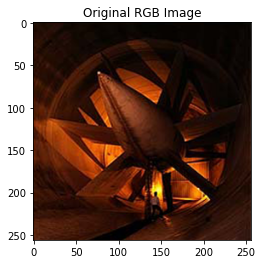

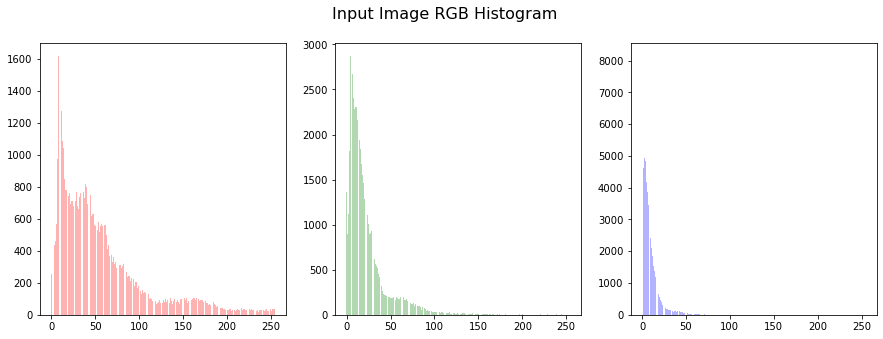

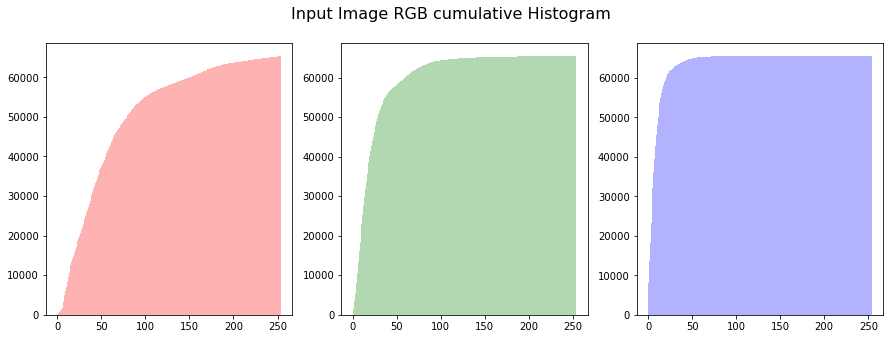

In [6]:
#########################
# 입력영상의 히스토그램 #
#########################
plt.imshow(rgbimg)
plt.title("Original RGB Image")
i=Image.open("C:/Users/ISIA/Pictures/test_image.jpg")
histogram=i.histogram()
Red=histogram[0:255]      # 빨간색 표시
Green=histogram[256:511]  # 초록색 표시
Blue=histogram[512:767]   # 파란색 표시

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)             # 빨간색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Red[i], color = 'r',alpha=0.3)
plt.subplot(1,3,2)              # 초록색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Green[i], color = 'g',alpha=0.3)
plt.subplot(1,3,3)              # 파란색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Blue[i], color = 'b',alpha=0.3)
plt.suptitle("Input Image RGB Histogram", fontsize=16)
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1) 
x = np.arange(len(Red))
plt.hist(x,bins = 255,weights = Red, color = "Red",alpha=0.3,cumulative=True)  # 누적 분포 함수 (cumulative=True)
plt.subplot(1,3,2) 
x = np.arange(len(Green))
plt.hist(x,bins = 255,weights = Green,color = "Green",alpha=0.3, cumulative=True) # 누적 분포 함수 (cumulative=True)
plt.subplot(1,3,3) 
x = np.arange(len(Blue))
plt.hist(x,bins = 255,weights = Blue,color = "Blue",alpha=0.3, cumulative=True) # 누적 분포 함수 (cumulative=True)
plt.suptitle("Input Image RGB cumulative Histogram", fontsize=16)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


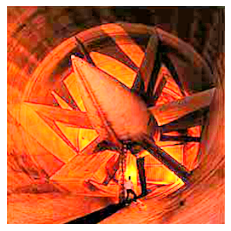

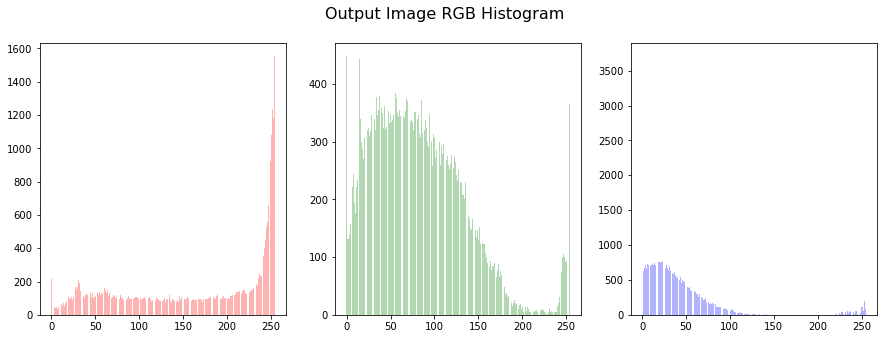

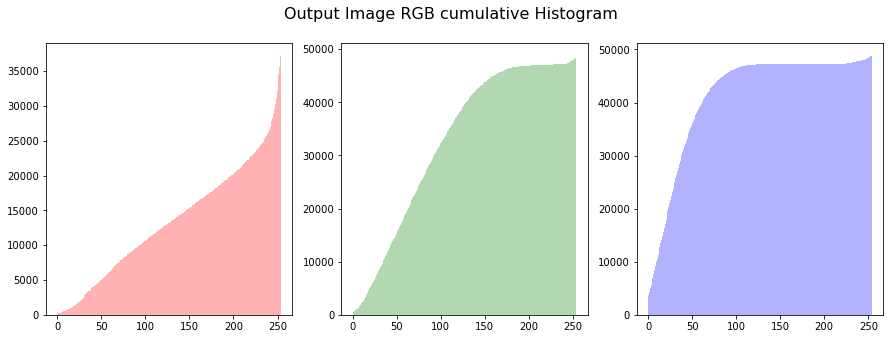

In [7]:
#########################
# 출력영상의 히스토그램 #
#########################

im_array = np.array(heimghsi) 
plt.imshow(im_array) 
plt.axis('off')
plt.savefig("C:/Users/ISIA/Pictures/output_image.jpg") # 이미지 저장

i=Image.open("C:/Users/ISIA/Pictures/output_image.jpg") # 저장한 이미지 불러오기
histogram=i.histogram()
Red=histogram[0:255]
Green=histogram[256:511]
Blue=histogram[512:767] 
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)             # 빨간색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Red[i], color = 'r',alpha=0.3)
plt.subplot(1,3,2)              # 초록색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Green[i], color = 'g',alpha=0.3)
plt.subplot(1,3,3)              # 파란색 히스토그램 그래프
for i in range(0, 255):
    plt.bar(i, Blue[i], color = 'b',alpha=0.3)
plt.suptitle("Output Image RGB Histogram", fontsize=16)
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)      
x = np.arange(len(Red))
plt.hist(x,bins = 255,weights = Red, color = "Red",alpha=0.3, cumulative=True) # 누적 분포 함수 (cumulative=True)
plt.subplot(1,3,2) 
x = np.arange(len(Green))
plt.hist(x,bins = 255,weights = Green,color = "Green",alpha=0.3, cumulative=True) # 누적 분포 함수 (cumulative=True)
plt.subplot(1,3,3) 
x = np.arange(len(Blue))
plt.hist(x,bins = 255,weights = Blue,color = "Blue",alpha=0.3, cumulative=True) # 누적 분포 함수 (cumulative=True)
plt.suptitle("Output Image RGB cumulative Histogram", fontsize=16)
plt.show()